large gpu ram, but utilization = 10%

In [17]:
import torch
import matplotlib.pyplot as plt

# ------------------------------------------------------
# GPU Setup
# ------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ------------------------------------------------------
# Environment/Task Parameters
# ------------------------------------------------------
ROWS, COLS = 32, 17
VEL_LEN = 5  # velocities from 0..4
ACTIONS = [
    (0, 0),  (0, 1),  (0, -1),
    (1, 0),  (1, 1),  (1, -1),
    (-1, 0), (-1, 1), (-1, -1)
]
ACT_LEN = len(ACTIONS)

# Monte Carlo control parameters
epsilon = 0.1
gamma = 1.0
R_step = -1  # reward per step

# ------------------------------------------------------
# Create track on GPU (1 = boundary/off-track)
# ------------------------------------------------------
track = torch.zeros((ROWS, COLS), dtype=torch.int, device=device)
track[31, 0:3] = 1
track[30, 0:2] = 1
track[29, 0:2] = 1
track[28, 0]   = 1
track[0:18, 0] = 1
track[0:10, 1] = 1
track[0:3,  2] = 1
track[0:26, 9:] = 1
track[25, 9]   = 0

# ------------------------------------------------------
# Define starting columns and finish set
# (Keep finish as a Python set for membership checks)
# ------------------------------------------------------
start_cols = list(range(3, 9))  # [3,4,5,6,7,8]
finish_cells = {
    (26, COLS-1), (27, COLS-1), (28, COLS-1),
    (29, COLS-1), (30, COLS-1), (31, COLS-1)
}

# ------------------------------------------------------
# Precompute valid actions for each (h,v)
# (Still a Python list-of-lists for quick referencing)
# ------------------------------------------------------
valid_actions = []
for h in range(VEL_LEN):
    row = []
    for v in range(VEL_LEN):
        vacts = []
        for i, (dh, dv) in enumerate(ACTIONS):
            nh = h + dh
            nv = v + dv
            # velocity must remain in [0..4], cannot be (0,0) except at start
            if 0 <= nh < VEL_LEN and 0 <= nv < VEL_LEN and not (nh == 0 and nv == 0):
                vacts.append(i)
        row.append(vacts)
    valid_actions.append(row)

# ------------------------------------------------------
# Initialize Q, C, and policy on GPU
#   Q, C ~ shape (ROWS, COLS, VEL_LEN, VEL_LEN, ACT_LEN)
#   policy ~ shape (ROWS, COLS, VEL_LEN, VEL_LEN)
# ------------------------------------------------------
Q = (torch.rand((ROWS, COLS, VEL_LEN, VEL_LEN, ACT_LEN), device=device) * 400) - 500
C = torch.zeros((ROWS, COLS, VEL_LEN, VEL_LEN, ACT_LEN), device=device)
policy = torch.zeros((ROWS, COLS, VEL_LEN, VEL_LEN), dtype=torch.long, device=device)

# Initialize policy with argmax over Q
for r in range(ROWS):
    for c in range(COLS):
        for h in range(VEL_LEN):
            for v in range(VEL_LEN):
                best_action = torch.argmax(Q[r, c, h, v]).item()
                policy[r, c, h, v] = best_action

# ------------------------------------------------------
# Utility: create random start states in parallel
#   Each start state: row=0, col in [3..8], velocity=(1,1)
# ------------------------------------------------------
def random_start_states(batch_size):
    """
    Return a (batch_size, 4) LongTensor of states (row, col, h, v).
    On GPU, with row=0, col random from [3..8], h=1, v=1.
    """
    states = torch.zeros((batch_size, 4), dtype=torch.long, device=device)
    states[:, 0] = 0  # row=0
    # random columns from [3..8]
    cols = torch.randint(low=3, high=9, size=(batch_size,), device=device)
    states[:, 1] = cols
    # h=1, v=1
    states[:, 2] = 1
    states[:, 3] = 1
    return states

# ------------------------------------------------------
# We want to sample many episodes in parallel (batch).
# We'll store the entire trajectory in GPU tensors of shape [batch_size, max_steps].
# Then do the backward MC update.
#
# "Episode" ends for an environment when it crosses finish line.
# If it hits boundary, it resets to a new start, continuing the same "episode".
# This is the usual racetrack logic, but in parallel.
# ------------------------------------------------------

def sample_batch_episodes(batch_size, epsilon, noise=True, max_steps=2000):
    """
    Simulate 'batch_size' environments in parallel up to max_steps.
    Return:
      states_buffer:  (batch_size, max_steps, 4)   int
      actions_buffer: (batch_size, max_steps)      int
      probs_buffer:   (batch_size, max_steps)      float
      lengths:        (batch_size,) how many steps each env took before finishing
    """
    # Initialize
    states = random_start_states(batch_size)  # shape [batch_size, 4]
    done = torch.zeros(batch_size, dtype=torch.bool, device=device)
    lengths = torch.zeros(batch_size, dtype=torch.long, device=device)  # track how many steps each env used

    # Buffers to store transitions
    states_buffer = torch.zeros((batch_size, max_steps, 4), dtype=torch.long, device=device)
    actions_buffer = torch.zeros((batch_size, max_steps), dtype=torch.long, device=device)
    probs_buffer = torch.zeros((batch_size, max_steps), dtype=torch.float, device=device)

    for step_i in range(max_steps):
        # record current states
        states_buffer[:, step_i] = states

        # pick the policy action (greedy)
        chosen_actions = policy[
            states[:, 0],
            states[:, 1],
            states[:, 2],
            states[:, 3]
        ].clone()  # shape [batch_size], int

        # We'll do epsilon-soft + noise
        # 1) figure out valid actions for each environment
        # 2) decide if we pick random or policy
        # 3) handle noise override with prob=0.1

        # random mask for epsilon
        rand_vals = torch.rand(batch_size, device=device)  # in [0,1)
        noise_vals = torch.rand(batch_size, device=device)  # for 0.1 noise

        # We'll store final action + prob in these arrays
        final_actions = chosen_actions.clone()
        final_probs = torch.zeros(batch_size, device=device)

        for b in range(batch_size):
            if done[b]:
                # If env is already done, no more transitions
                final_actions[b] = -1
                final_probs[b] = 1.0
                continue

            r = states[b, 0].item()
            c = states[b, 1].item()
            h = states[b, 2].item()
            v = states[b, 3].item()
            vacts = valid_actions[h][v]  # Python list of valid action indices

            # If the policy-chosen action is not valid, forcibly random
            if chosen_actions[b].item() not in vacts:
                # random among valid
                final_actions[b] = vacts[torch.randint(len(vacts), (1,)).item()]
                final_probs[b] = 1.0 / len(vacts)
            else:
                # Epsilon-soft
                if rand_vals[b].item() < epsilon:
                    # random
                    ra = vacts[torch.randint(len(vacts), (1,)).item()]
                    final_actions[b] = ra
                    final_probs[b] = epsilon / len(vacts)
                else:
                    # policy
                    final_actions[b] = chosen_actions[b]
                    final_probs[b] = (1 - epsilon) + (epsilon / len(vacts))

            # noise override with prob=0.1
            if noise and noise_vals[b].item() < 0.1:
                final_actions[b] = 0  # index 0 => (0,0)
                final_probs[b] = 0.1

        actions_buffer[:, step_i] = final_actions
        probs_buffer[:, step_i] = final_probs

        # Now compute next states for each environment
        # skip those done
        dh_dv = torch.tensor(ACTIONS, device=device, dtype=torch.long)[final_actions.clamp(min=0)]
        # shape [batch_size, 2], but for "done" or -1 actions, we clamp to index 0 => (0,0).

        # new velocity
        new_hv = states[:, 2:4] + dh_dv
        # new row/col
        new_row = states[:, 0] + (new_hv[:, 1] - 1)
        new_col = states[:, 1] + (new_hv[:, 0] - 1)

        # update each environment if not done
        for b in range(batch_size):
            if done[b]:
                continue

            # if final_actions[b] == -1 => skip
            if final_actions[b] < 0:
                # means we didn't actually pick an action because done
                continue

            nr = new_row[b].item()
            nc = new_col[b].item()
            nh = new_hv[b, 0].item()
            nv = new_hv[b, 1].item()

            # check finish
            if (nr, nc) in finish_cells:
                # done
                done[b] = True
                lengths[b] = step_i + 1
            else:
                # check boundary
                if (nr < 0 or nr >= ROWS or nc < 0 or nc >= COLS or track[nr, nc].item() == 1):
                    # crash => reset
                    reset = random_start_states(1)[0]
                    states[b] = reset
                else:
                    # normal
                    states[b, 0] = nr
                    states[b, 1] = nc
                    states[b, 2] = nh
                    states[b, 3] = nv

        if torch.all(done):
            break

    # If some environments never finished, set length to max_steps
    lengths[~done] = max_steps
    return states_buffer, actions_buffer, probs_buffer, lengths

# ------------------------------------------------------
# Off-policy MC update in a batched manner
#   We'll do a backward pass for each environment's trajectory.
#   The difference: we store transitions in GPU arrays,
#   so we can do the backward pass more quickly than a Python list-of-lists.
# ------------------------------------------------------
def offpolicy_update(states_buffer, actions_buffer, probs_buffer, lengths):
    """
    states_buffer:  (batch_size, max_steps, 4)
    actions_buffer: (batch_size, max_steps)
    probs_buffer:   (batch_size, max_steps)
    lengths:        (batch_size,) - how many steps each env took
    """
    batch_size, max_steps = actions_buffer.shape

    # We'll do the standard MC backward pass:
    #   G <- 0, W <- 1
    #   for t in T-1 down to 0:
    #       G = gamma*G + R_step
    #       C[state, action] += W
    #       Q[state, action] += W*(G - Q[state, action]) / C[state, action]
    #       policy[state] = argmax(Q[state, valid_acts])
    #       if action != policy[state], break
    #       W = W / prob
    #
    # We do this for each environment in the batch.

    for b in range(batch_size):
        T = lengths[b].item()  # how many steps
        if T == 0:
            continue

        G = 0.0
        W = 1.0
        for t in reversed(range(T)):
            # read from buffer
            r, c, h, v = states_buffer[b, t].tolist()
            a = actions_buffer[b, t].item()
            prob = probs_buffer[b, t].item()

            # If a < 0 => means no action (done), skip
            if a < 0:
                continue

            G = gamma * G + R_step
            C[r, c, h, v, a] += W
            old_q = Q[r, c, h, v, a]
            Q[r, c, h, v, a] = old_q + W * (G - old_q) / C[r, c, h, v, a]

            # Update policy => greedy among valid
            vacts = valid_actions[h][v]
            q_slice = Q[r, c, h, v, vacts]
            best_idx = torch.argmax(q_slice).item()
            best_action = vacts[best_idx]
            policy[r, c, h, v] = best_action

            # off-policy break
            if a != best_action:
                break

            # update W
            W = W / prob if prob > 0 else 1.0

# ------------------------------------------------------
# Evaluate the current policy by a single (noise-free) episode
# ------------------------------------------------------
def evaluate_trajectory():
    """
    Run a single (noise-free) episode from a random start,
    following the current greedy policy. Return (length, path).
    """
    state = random_start_states(1)[0]  # shape [4]
    path = []
    step_count = 0
    while True:
        r, c, h, v = state.tolist()
        path.append((r, c, h, v))
        if (r, c) in finish_cells:
            return step_count, path

        # pick the policy action
        a = policy[r, c, h, v].item()
        dh, dv = ACTIONS[a]
        nh = h + dh
        nv = v + dv
        nr = r + (nv - 1)
        nc = c + (nh - 1)

        # boundary check
        if nr < 0 or nr >= ROWS or nc < 0 or nc >= COLS or track[nr, nc].item() == 1:
            # crash => reset
            state = random_start_states(1)[0]
        else:
            state = torch.tensor([nr, nc, nh, nv], device=device)
        step_count += 1

# ------------------------------------------------------
# Main training loop
# ------------------------------------------------------
def main():
    num_iterations = 16384     # number of batch iterations
    batch_size = 65536          # increase for more GPU usage
    max_steps = 4096          # max steps per parallel rollout

    rewards_log = []

    for i in range(num_iterations):
        # sample a batch
        states_buf, actions_buf, probs_buf, lengths = sample_batch_episodes(
            batch_size, epsilon, noise=True, max_steps=max_steps
        )

        # off-policy update
        offpolicy_update(states_buf, actions_buf, probs_buf, lengths)

        # every so often, do a noise-free evaluation
        if i % 50 == 0:
            T_eval, path = evaluate_trajectory()
            # return = -T_eval if each step costs -1
            rewards_log.append(-T_eval)
            print(f"Iteration {i}: T_eval={T_eval}, Return={-T_eval}")

    # Plot the learning curve
    plt.plot(rewards_log)
    plt.xlabel("Evaluation checkpoint (every 50 iterations)")
    plt.ylabel("Return (negative of steps)")
    plt.title("Off-Policy MC Control (Batch) on Racetrack (GPU)")
    plt.show()

    # Show final example trajectories
    for i in range(3):
        T_opt, path = evaluate_trajectory()
        print(f"\nOptimal (noise-free) trajectory #{i+1}, length={T_opt}")
        print("Path:", path)
        print("Actions are implied by policy, reward =", -T_opt)


if __name__ == "__main__":
    main()


Using device: cuda


KeyboardInterrupt: 

too long to run the model(Monte Carlo Off-policy control) training-> to be honest

thinking about next step

Using device: cuda
Episode 50/3000, steps=13082, eps=0.050, ep_reward=-14
Episode 100/3000, steps=15188, eps=0.050, ep_reward=-12
Episode 150/3000, steps=16368, eps=0.050, ep_reward=-11
Episode 200/3000, steps=17503, eps=0.050, ep_reward=-28
Episode 250/3000, steps=18709, eps=0.050, ep_reward=-15
Episode 300/3000, steps=20077, eps=0.050, ep_reward=-13
Episode 350/3000, steps=21129, eps=0.050, ep_reward=-29
Episode 400/3000, steps=22296, eps=0.050, ep_reward=-60
Episode 450/3000, steps=23125, eps=0.050, ep_reward=-12
Episode 500/3000, steps=24111, eps=0.050, ep_reward=-72
Episode 550/3000, steps=25007, eps=0.050, ep_reward=-32
Episode 600/3000, steps=25860, eps=0.050, ep_reward=-13
Episode 650/3000, steps=26870, eps=0.050, ep_reward=-44
Episode 700/3000, steps=27767, eps=0.050, ep_reward=-16
Episode 750/3000, steps=28718, eps=0.050, ep_reward=-14
Episode 800/3000, steps=29590, eps=0.050, ep_reward=-29
Episode 850/3000, steps=30469, eps=0.050, ep_reward=-14
Episode 900/3000, steps=31398,

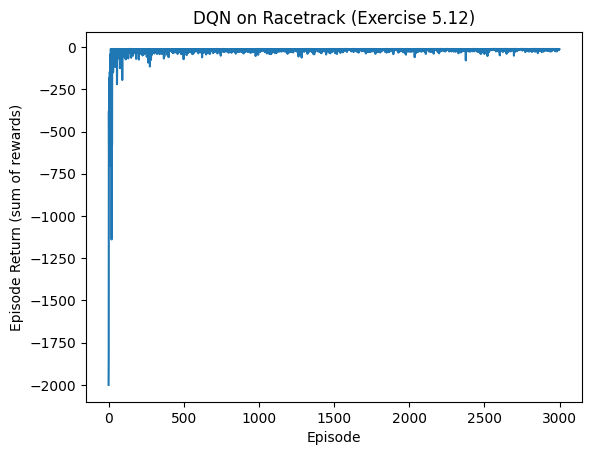


Evaluating final policy with noise disabled (for 3 episodes):
Eval Episode 1: steps=13, return=-13, path_len=13
Eval Episode 2: steps=11, return=-11, path_len=11
Eval Episode 3: steps=11, return=-11, path_len=11


In [18]:
import math
import random
import collections
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==============================================
# Environment definition: RacetrackEnv
# ==============================================
class RacetrackEnv:
    """
    A single-environment version of the Racetrack problem from Sutton & Barto (Exercise 5.12),
    but with DQN-friendly step() interface.

    Observations:
      state = (row, col, v_row, v_col)
        - row in [0..31], col in [0..16]
        - v_row, v_col in [0..4]  (the "velocity" components),
          but cannot both be 0 except at the starting line.
    
    Actions:
      9 discrete actions = increments (dh, dv) in { -1, 0, +1 } x { -1, 0, +1 }
      But we interpret them as velocity increments.
      We also have a 10% chance to override the chosen increments with (0,0) (noise).

    Reward:
      -1 per step, until crossing finish line => episode done.

    If we hit boundary (off-track), we reset to a random start state (the same episode continues).
    If we cross the finish line, episode ends.
    """
    ACTIONS = [
        (0, 0),   # index 0
        (0, 1),   # index 1
        (0, -1),  # index 2
        (1, 0),   # index 3
        (1, 1),   # index 4
        (1, -1),  # index 5
        (-1, 0),  # index 6
        (-1, 1),  # index 7
        (-1, -1)  # index 8
    ]
    NUM_ACTIONS = len(ACTIONS)

    def __init__(self, device='cpu', noise_prob=0.1):
        self.rows = 32
        self.cols = 17
        self.vel_max = 4
        self.noise_prob = noise_prob
        self.device = device

        # Track boundary: 1 => boundary/off-track, 0 => on track
        self.track = np.zeros((self.rows, self.cols), dtype=int)
        # Fill the boundaries (like in the problem statement)
        self.track[31, 0:3] = 1
        self.track[30, 0:2] = 1
        self.track[29, 0:2] = 1
        self.track[28, 0]   = 1
        self.track[0:18, 0] = 1
        self.track[0:10, 1] = 1
        self.track[0:3,  2] = 1
        self.track[0:26, 9:] = 1
        self.track[25, 9]   = 0

        # Starting columns, finish line
        self.start_cols = list(range(3, 9))  # [3..8]
        self.finish_cells = {
            (26, self.cols-1), (27, self.cols-1), (28, self.cols-1),
            (29, self.cols-1), (30, self.cols-1), (31, self.cols-1)
        }

        # We will keep current state
        self.state = None
        self.reset()

    def reset(self):
        """
        Reset to a random start state on row=0, col in [3..8], velocity=(0,0).
        Return the initial state as a PyTorch tensor (optionally).
        """
        start_col = random.choice(self.start_cols)
        self.state = (0, start_col, 0, 0)
        return self._get_obs()

    def step(self, action_idx):
        """
        Take one step in the environment using action index in [0..8].
        Returns: (next_state, reward, done, info)
        - If off-track, we reset to start line, same episode continues, reward is still -1, done=False
        - If cross finish, done=True
        """
        r, c, vr, vc = self.state
        # Chosen increments
        dh, dv = self.ACTIONS[action_idx]

        # With probability noise_prob, override increments to (0,0)
        if random.random() < self.noise_prob:
            dh, dv = 0, 0

        # Next velocity
        new_vr = vr + dh
        new_vc = vc + dv
        # Clip velocities to [0..4]
        new_vr = max(0, min(self.vel_max, new_vr))
        new_vc = max(0, min(self.vel_max, new_vc))

        # Next position
        nr = r + new_vr
        nc = c + new_vc

        reward = -1
        done = False

        # Check finish line
        if (nr, nc) in self.finish_cells:
            # Episode ends
            done = True
            next_state = (nr, nc, new_vr, new_vc)
            self.state = next_state
            return self._get_obs(), reward, done, {}

        # Check off-track
        if nr < 0 or nr >= self.rows or nc < 0 or nc >= self.cols or self.track[nr, nc] == 1:
            # Crash => reset to start line (0, random_col, 0,0), but done=False
            start_col = random.choice(self.start_cols)
            next_state = (0, start_col, 0, 0)
            self.state = next_state
            return self._get_obs(), reward, done, {}

        # Otherwise normal
        next_state = (nr, nc, new_vr, new_vc)
        self.state = next_state
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        """
        Return the current state as a tensor on self.device: shape (4,)
        [row, col, v_row, v_col].
        """
        r, c, vr, vc = self.state
        return torch.tensor([r, c, vr, vc], dtype=torch.float, device=self.device)


# ==============================================
# DQN Neural Network
# ==============================================
class QNetwork(nn.Module):
    """
    A simple feed-forward network mapping (row, col, vr, vc) -> Q-values for 9 actions.
    You can expand this if you like (more layers, bigger layers).
    """
    def __init__(self, hidden_size=128):
        super().__init__()
        # Input dimension = 4, output dimension = 9
        self.net = nn.Sequential(
            nn.Linear(4, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 9)  # 9 actions
        )

    def forward(self, x):
        # x shape: (batch_size, 4)
        return self.net(x)


# ==============================================
# Replay Buffer
# ==============================================
class ReplayBuffer:
    def __init__(self, capacity, device='cpu'):
        self.capacity = capacity
        self.device = device
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)

        states = torch.stack(states)  # each is shape (4,)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device)
        rewards = torch.tensor(rewards, dtype=torch.float, device=self.device)
        next_states = torch.stack(next_states)
        dones = torch.tensor(dones, dtype=torch.float, device=self.device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


# ==============================================
# DQN Training Loop
# ==============================================
def train_dqn(
    env,
    qnet,
    target_qnet,
    buffer,
    num_episodes=2000,
    batch_size=128,
    gamma=1.0,
    lr=1e-3,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=1000,
    sync_target_steps=1000,
    max_steps_per_episode=500,
):
    """
    Train the QNetwork with standard DQN + target network + replay buffer.

    Returns: a list of episode rewards for plotting
    """
    optimizer = optim.Adam(qnet.parameters(), lr=lr)
    steps_done = 0
    episode_rewards = []

    def epsilon_by_step(step):
        # simple linear schedule from epsilon_start down to epsilon_end
        return max(epsilon_end, epsilon_start - (step / epsilon_decay)*(epsilon_start - epsilon_end))

    for ep in range(num_episodes):
        state = env.reset()  # shape (4,)
        ep_reward = 0
        for t in range(max_steps_per_episode):
            steps_done += 1
            # epsilon-greedy
            eps = epsilon_by_step(steps_done)
            if random.random() < eps:
                action = random.randint(0, env.NUM_ACTIONS-1)
            else:
                with torch.no_grad():
                    qvals = qnet(state.unsqueeze(0))  # shape (1,9)
                    action = qvals.argmax(dim=1).item()

            next_state, reward, done, _info = env.step(action)
            ep_reward += reward

            # store transition
            buffer.push(state, action, reward, next_state, done)

            state = next_state

            # DQN update
            if len(buffer) >= batch_size:
                states_b, actions_b, rewards_b, next_states_b, dones_b = buffer.sample(batch_size)

                # Q(s,a)
                qvals_b = qnet(states_b)  # shape (batch_size, 9)
                chosen_qvals = qvals_b.gather(1, actions_b.unsqueeze(1)).squeeze(1)

                # Target
                with torch.no_grad():
                    # Double DQN style (optional):
                    # a' = argmax(qnet(next_states_b))
                    # target = rewards_b + gamma*(target_qnet(next_states_b).gather(1, a').squeeze(1))*(1-dones_b)
                    # If you want simpler DQN:
                    next_qvals = target_qnet(next_states_b).max(dim=1)[0]
                    target = rewards_b + gamma * next_qvals * (1 - dones_b)

                loss = nn.MSELoss()(chosen_qvals, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # sync target
            if steps_done % sync_target_steps == 0:
                target_qnet.load_state_dict(qnet.state_dict())

            if done:
                break

        episode_rewards.append(ep_reward)
        if (ep+1) % 50 == 0:
            print(f"Episode {ep+1}/{num_episodes}, steps={steps_done}, eps={eps:.3f}, ep_reward={ep_reward}")

    return episode_rewards


# ==============================================
# Putting it all together
# ==============================================
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    # 1) Create environment
    env = RacetrackEnv(device=device, noise_prob=0.1)

    # 2) Create networks
    qnet = QNetwork(hidden_size=256).to(device)
    target_qnet = QNetwork(hidden_size=256).to(device)
    target_qnet.load_state_dict(qnet.state_dict())  # sync initially

    # 3) Create replay buffer
    replay_capacity = 100_000
    buffer = ReplayBuffer(replay_capacity, device=device)

    # 4) Train
    num_episodes = 3000
    batch_size = 256
    sync_target_steps = 1000

    rewards = train_dqn(
        env, qnet, target_qnet, buffer,
        num_episodes=num_episodes,
        batch_size=batch_size,
        gamma=1.0,
        lr=1e-3,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=10_000,  # how fast epsilon decays
        sync_target_steps=sync_target_steps,
        max_steps_per_episode=2000,
    )

    # 5) Plot training rewards
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Episode Return (sum of rewards)")
    plt.title("DQN on Racetrack (Exercise 5.12)")
    plt.show()

    # 6) Evaluate final policy with noise-free episodes
    print("\nEvaluating final policy with noise disabled (for 3 episodes):")
    old_noise_prob = env.noise_prob
    env.noise_prob = 0.0
    for i in range(3):
        state = env.reset()
        ep_reward = 0
        done = False
        steps = 0
        path = []
        while not done and steps < 2000:
            with torch.no_grad():
                qvals = qnet(state.unsqueeze(0))  # shape (1,9)
                action = qvals.argmax(dim=1).item()
            next_state, reward, done, _info = env.step(action)
            path.append((state[0].item(), state[1].item(), state[2].item(), state[3].item()))
            ep_reward += reward
            state = next_state
            steps += 1
        print(f"Eval Episode {i+1}: steps={steps}, return={ep_reward}, path_len={len(path)}")
    env.noise_prob = old_noise_prob


if __name__ == "__main__":
    main()


Why do we still see some episodes with −60−60 or −72−72 reward?

- Occasionally the agent crashes repeatedly and resets, or random noise sends it off-track. This can produce longer episodes with bigger negative returns.
- Even an optimal policy can have unlucky noise or resets.
Overall: The results look pretty good. The agent has a stable policy that reliably finishes in about 11–13 steps (noise-free). That’s likely near-optimal for this environment.